<a href="https://colab.research.google.com/github/glatham1/ECGR_4105_MachineLearning/blob/main/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kernel: linear
Best K: 5
Accuracy for best K:  0.9649122807017544
Precision for best K:  0.9574468085106383
Recall for best K:  0.9574468085106383
------
Kernel: poly
Best K: 4
Accuracy for best K:  0.9122807017543859
Precision for best K:  1.0
Recall for best K:  0.7872340425531915
------
Kernel: rbf
Best K: 10
Accuracy for best K:  0.9912280701754386
Precision for best K:  1.0
Recall for best K:  0.9787234042553191
------
Kernel: sigmoid
Best K: 7
Accuracy for best K:  0.956140350877193
Precision for best K:  0.9772727272727273
Recall for best K:  0.9148936170212766
------


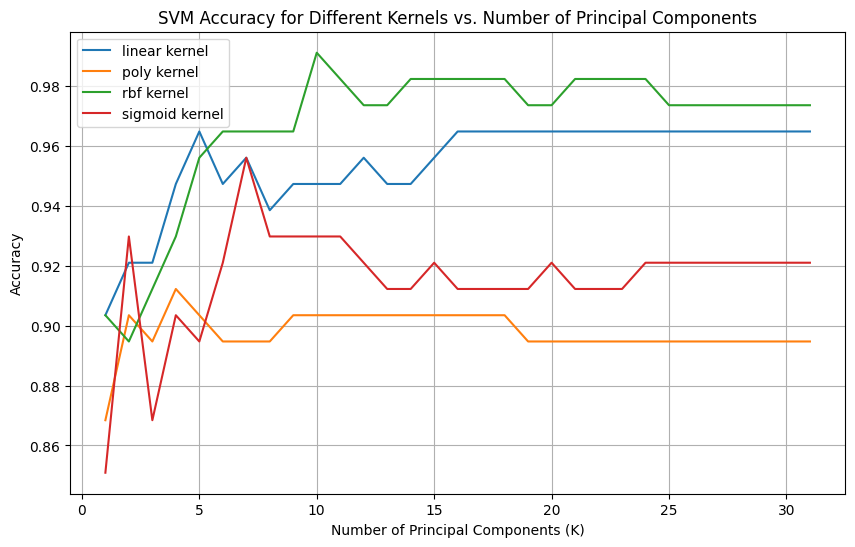

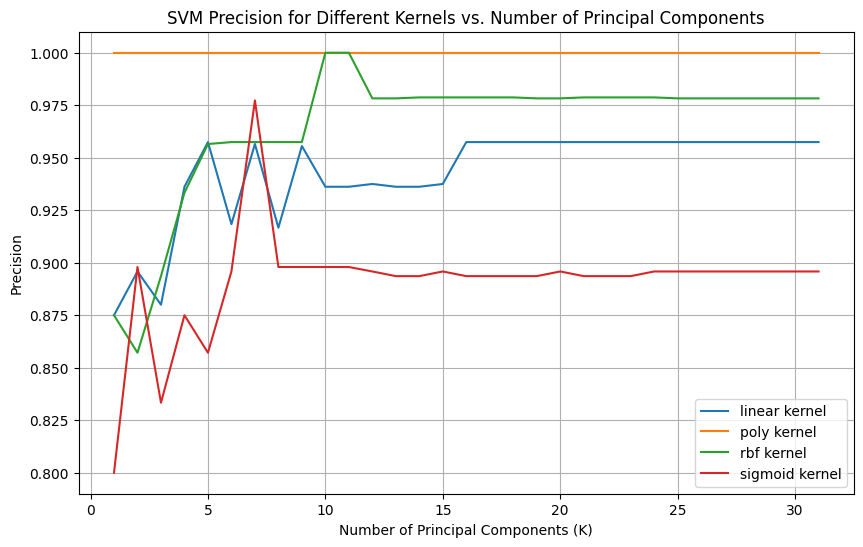

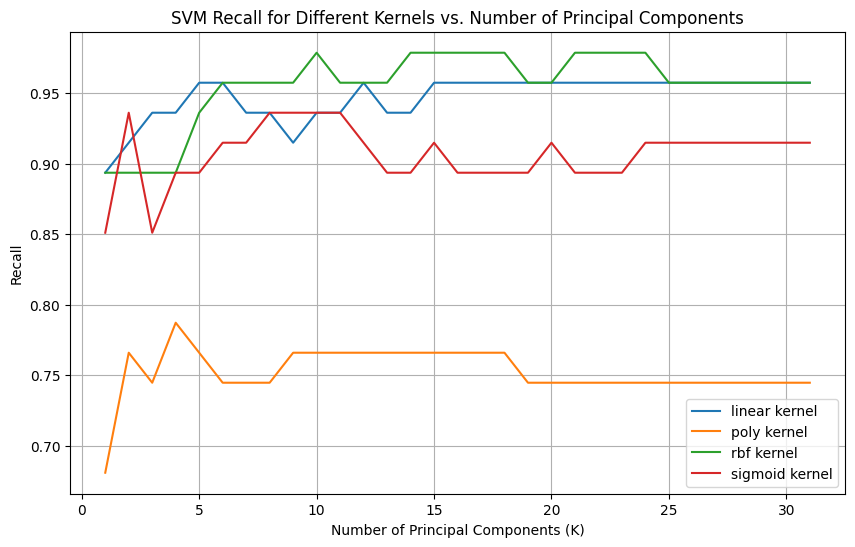

In [3]:
# Problem 1

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.impute import SimpleImputer

# Load the cancer dataset
df_cancer = pd.read_csv('cancer.csv')
df_cancer['diagnosis'] = df_cancer['diagnosis'].map({'M': 1, 'B': 0})
X_cancer = df_cancer.drop('diagnosis', axis=1)
y_cancer = df_cancer['diagnosis']

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_cancer_imputed = imputer.fit_transform(X_cancer)

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer_imputed)

# Split the dataset
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer_scaled, y_cancer, test_size=0.20, random_state=0)

# Identify optimum number of K principal components
max_features = X_cancer_scaled.shape[1]

# List of kernels to explore
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {kernel: {'ks': [], 'accuracies': [], 'precisions': [], 'recalls': []} for kernel in kernels}

for kernel in kernels:
    best_accuracy = 0
    best_k = 0
    best_precision = 0
    best_recall = 0

    for k in range(1, max_features + 1):
        # Apply PCA and reduce features
        pca = PCA(n_components=k)
        X_train_pca = pca.fit_transform(X_train_cancer)
        X_test_pca = pca.transform(X_test_cancer)

        # Train an SVM classifier with the current kernel
        clf = SVC(kernel=kernel)
        clf.fit(X_train_pca, y_train_cancer)
        y_pred = clf.predict(X_test_pca)

        accuracy = accuracy_score(y_test_cancer, y_pred)
        precision = precision_score(y_test_cancer, y_pred)
        recall = recall_score(y_test_cancer, y_pred)

        results[kernel]['ks'].append(k)
        results[kernel]['accuracies'].append(accuracy)
        results[kernel]['precisions'].append(precision)
        results[kernel]['recalls'].append(recall)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_precision = precision
            best_recall = recall

    print(f"Kernel: {kernel}")
    print(f"Best K: {best_k}")
    print("Accuracy for best K: ", best_accuracy)
    print("Precision for best K: ", best_precision)
    print("Recall for best K: ", best_recall)
    print("------")

# Plotting the results as per the new format
metrics = ['accuracies', 'precisions', 'recalls']
metric_names = ['accuracy', 'precision', 'recall']

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(10, 6))
    for kernel in kernels:
        plt.plot(results[kernel]['ks'], results[kernel][metric], label=f'{kernel} kernel')
    plt.xlabel('Number of Principal Components (K)')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'SVM {metric_name.capitalize()} for Different Kernels vs. Number of Principal Components')
    plt.legend()
    plt.grid(True)
    plt.show()


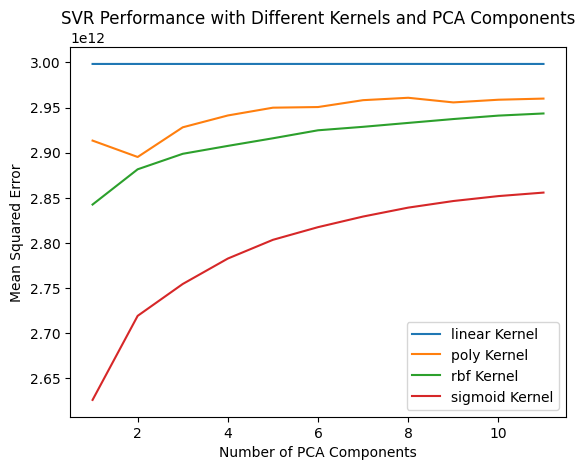

Optimal number of PCA components for linear kernel: 1
Optimal number of PCA components for poly kernel: 1
Optimal number of PCA components for rbf kernel: 1
Optimal number of PCA components for sigmoid kernel: 1


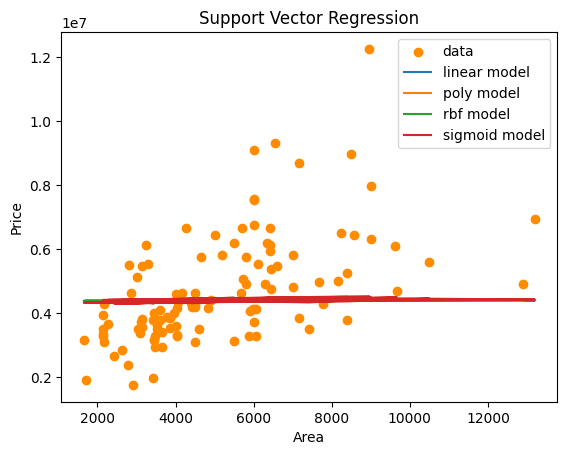

In [9]:
# Problem 2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

# Load the data
housing = pd.read_csv('Housing.csv')

# Preprocess the data
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[varlist] = housing[varlist].apply(binary_map)

# Selecting features and target variable
features = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X = housing[features]
y = housing['price']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Different kernels to be tested (Added 'sigmoid' to the list)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Store the models and predictions for plotting
models = {kernel: None for kernel in kernels}
predictions = {kernel: None for kernel in kernels}

# Function to train and evaluate SVR with PCA
def train_evaluate_svr(kernel, n_components):
    if kernel == 'rbf':
        model = SVR(kernel=kernel, C=1e3, gamma=0.1)
    elif kernel == 'poly':
        model = SVR(kernel=kernel, C=1e3, degree=2, gamma='scale')
    elif kernel == 'sigmoid':
        model = SVR(kernel=kernel, C=1e3, gamma='scale')
    else:
        model = SVR(kernel=kernel, C=1.0, gamma='auto')

    pipeline = make_pipeline(PCA(n_components=n_components), model)
    pipeline.fit(X_train_scaled, y_train)
    y_pred = pipeline.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    # Store model and predictions
    models[kernel] = model
    predictions[kernel] = y_pred

    return mse

# Determine the optimal number of components
max_components = min(X_train_scaled.shape[1], X_train_scaled.shape[0])
mse_results = {kernel: [] for kernel in kernels}
n_components_range = range(1, max_components + 1)
best_n_components = {kernel: None for kernel in kernels}

for n_components in n_components_range:
    for kernel in kernels:
        mse = train_evaluate_svr(kernel, n_components)
        mse_results[kernel].append(mse)
        # Store the best n_components
        if best_n_components[kernel] is None or mse < min(mse_results[kernel]):
            best_n_components[kernel] = n_components

# Plotting the results
for kernel in kernels:
    plt.plot(n_components_range, mse_results[kernel], label=f'{kernel} Kernel')

plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error')
plt.title('SVR Performance with Different Kernels and PCA Components')
plt.legend()
plt.show()

# Identifying the optimal number of components
for kernel in kernels:
    print(f"Optimal number of PCA components for {kernel} kernel: {best_n_components[kernel]}")

# Plotting the SVR results
plt.scatter(X_test['area'], y_test, color='darkorange', label='data')
for kernel in kernels:
    plt.plot(X_test['area'], predictions[kernel], label=f'{kernel} model')
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.show()
